In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
# Współczynnik przestępczości
# Część działek o powierzchni przekraczającej 2300 metrów kwadratowych.
# Część powierzchni działek działalności gospodarczych nie zajmujących się sprzedażą.
# Sztuczna zmienna rzeki Charles River (= 1 jeżeli działka znajduje się przy rzece; 0 w pozostałych przypadkach).
# Stopień koncentracji tlenków azotu(cząstek na 10 milionów).
# Średnia liczba pokoi w budynku.
# Część mieszkań zajętych przez właścicieli, które zostały wybudowane przed rokiem 1940.
# Średnia ważona odległości od pięciu stref, w których znajduje się najwięcej zakładów pracy.
# Indeks dostępności dróg szybkiego ruchu
# Pełny podatek od nieruchomości za 10000 $.
# Stosunek liczby uczniów do liczby nauczycieli.
# 1000 * (Bk - 0.63) ** 2, gdzie Bk ułamkiem czarnoskórej ludności miasta.
# % niższego statusu populacji.
test_data.shape

(102, 13)

In [5]:
train_data.shape

(404, 13)

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
all_scores

[2.0686525224459054,
 2.2371535867747694,
 2.8491345821040692,
 2.2463712043101243]

In [10]:
np.mean(all_scores)

2.3503279739087173

In [11]:
from keras import backend as K

K.clear_session()
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Liczba epok')
plt.ylabel('Sredni blad bezwzgledny')
plt.show()

<Figure size 640x480 with 1 Axes>

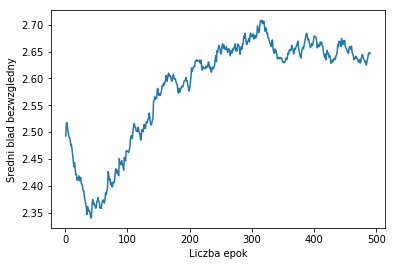

In [14]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Liczba epok')
plt.ylabel('Sredni blad bezwzgledny')
plt.show()

In [15]:
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [16]:
test_mae_score

2.679662601620543